In [1]:
#assumes you have cdo loaded when starting jupyter notebook
#The name of the case and where it is located
caseName = 'CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_no_pop_dust'
casePath = '/glade/scratch/jcoupe/dust_tests/archive/CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_no_pop_dust/ocn/hist/'

#The Range of years to analyze
startYear = 6
endYear = 6

#variable to analyze
var = 'IAGE'

#Longitude to analyze transect: 
transectLong = 61
#Saving Option
savePlot = False
saveLocation = '/glade/u/home/vgarza/Scripts/'

#Case to compare to: 
compareName = 'CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_new_dust'
comparePath = '/glade/scratch/jcoupe/dust_tests/archive/CESM2.1.3_CAM4_POPECO_CLM4_RTM_CICE5_SGLC_T31_g37_ciso_cocco_2000y_new_dust/ocn/hist/'


#option to regrid the case: 
regrid = True
#location to send remap (If selected)
remapLocation = '/glade/scratch/vgarza/ScriptTempOutput/' 

/glade/work/vgarza/my_npl_clone1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/vgarza/my_npl_clone1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/vgarza/my_npl_clone1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/vgarza/my_npl_clone1/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


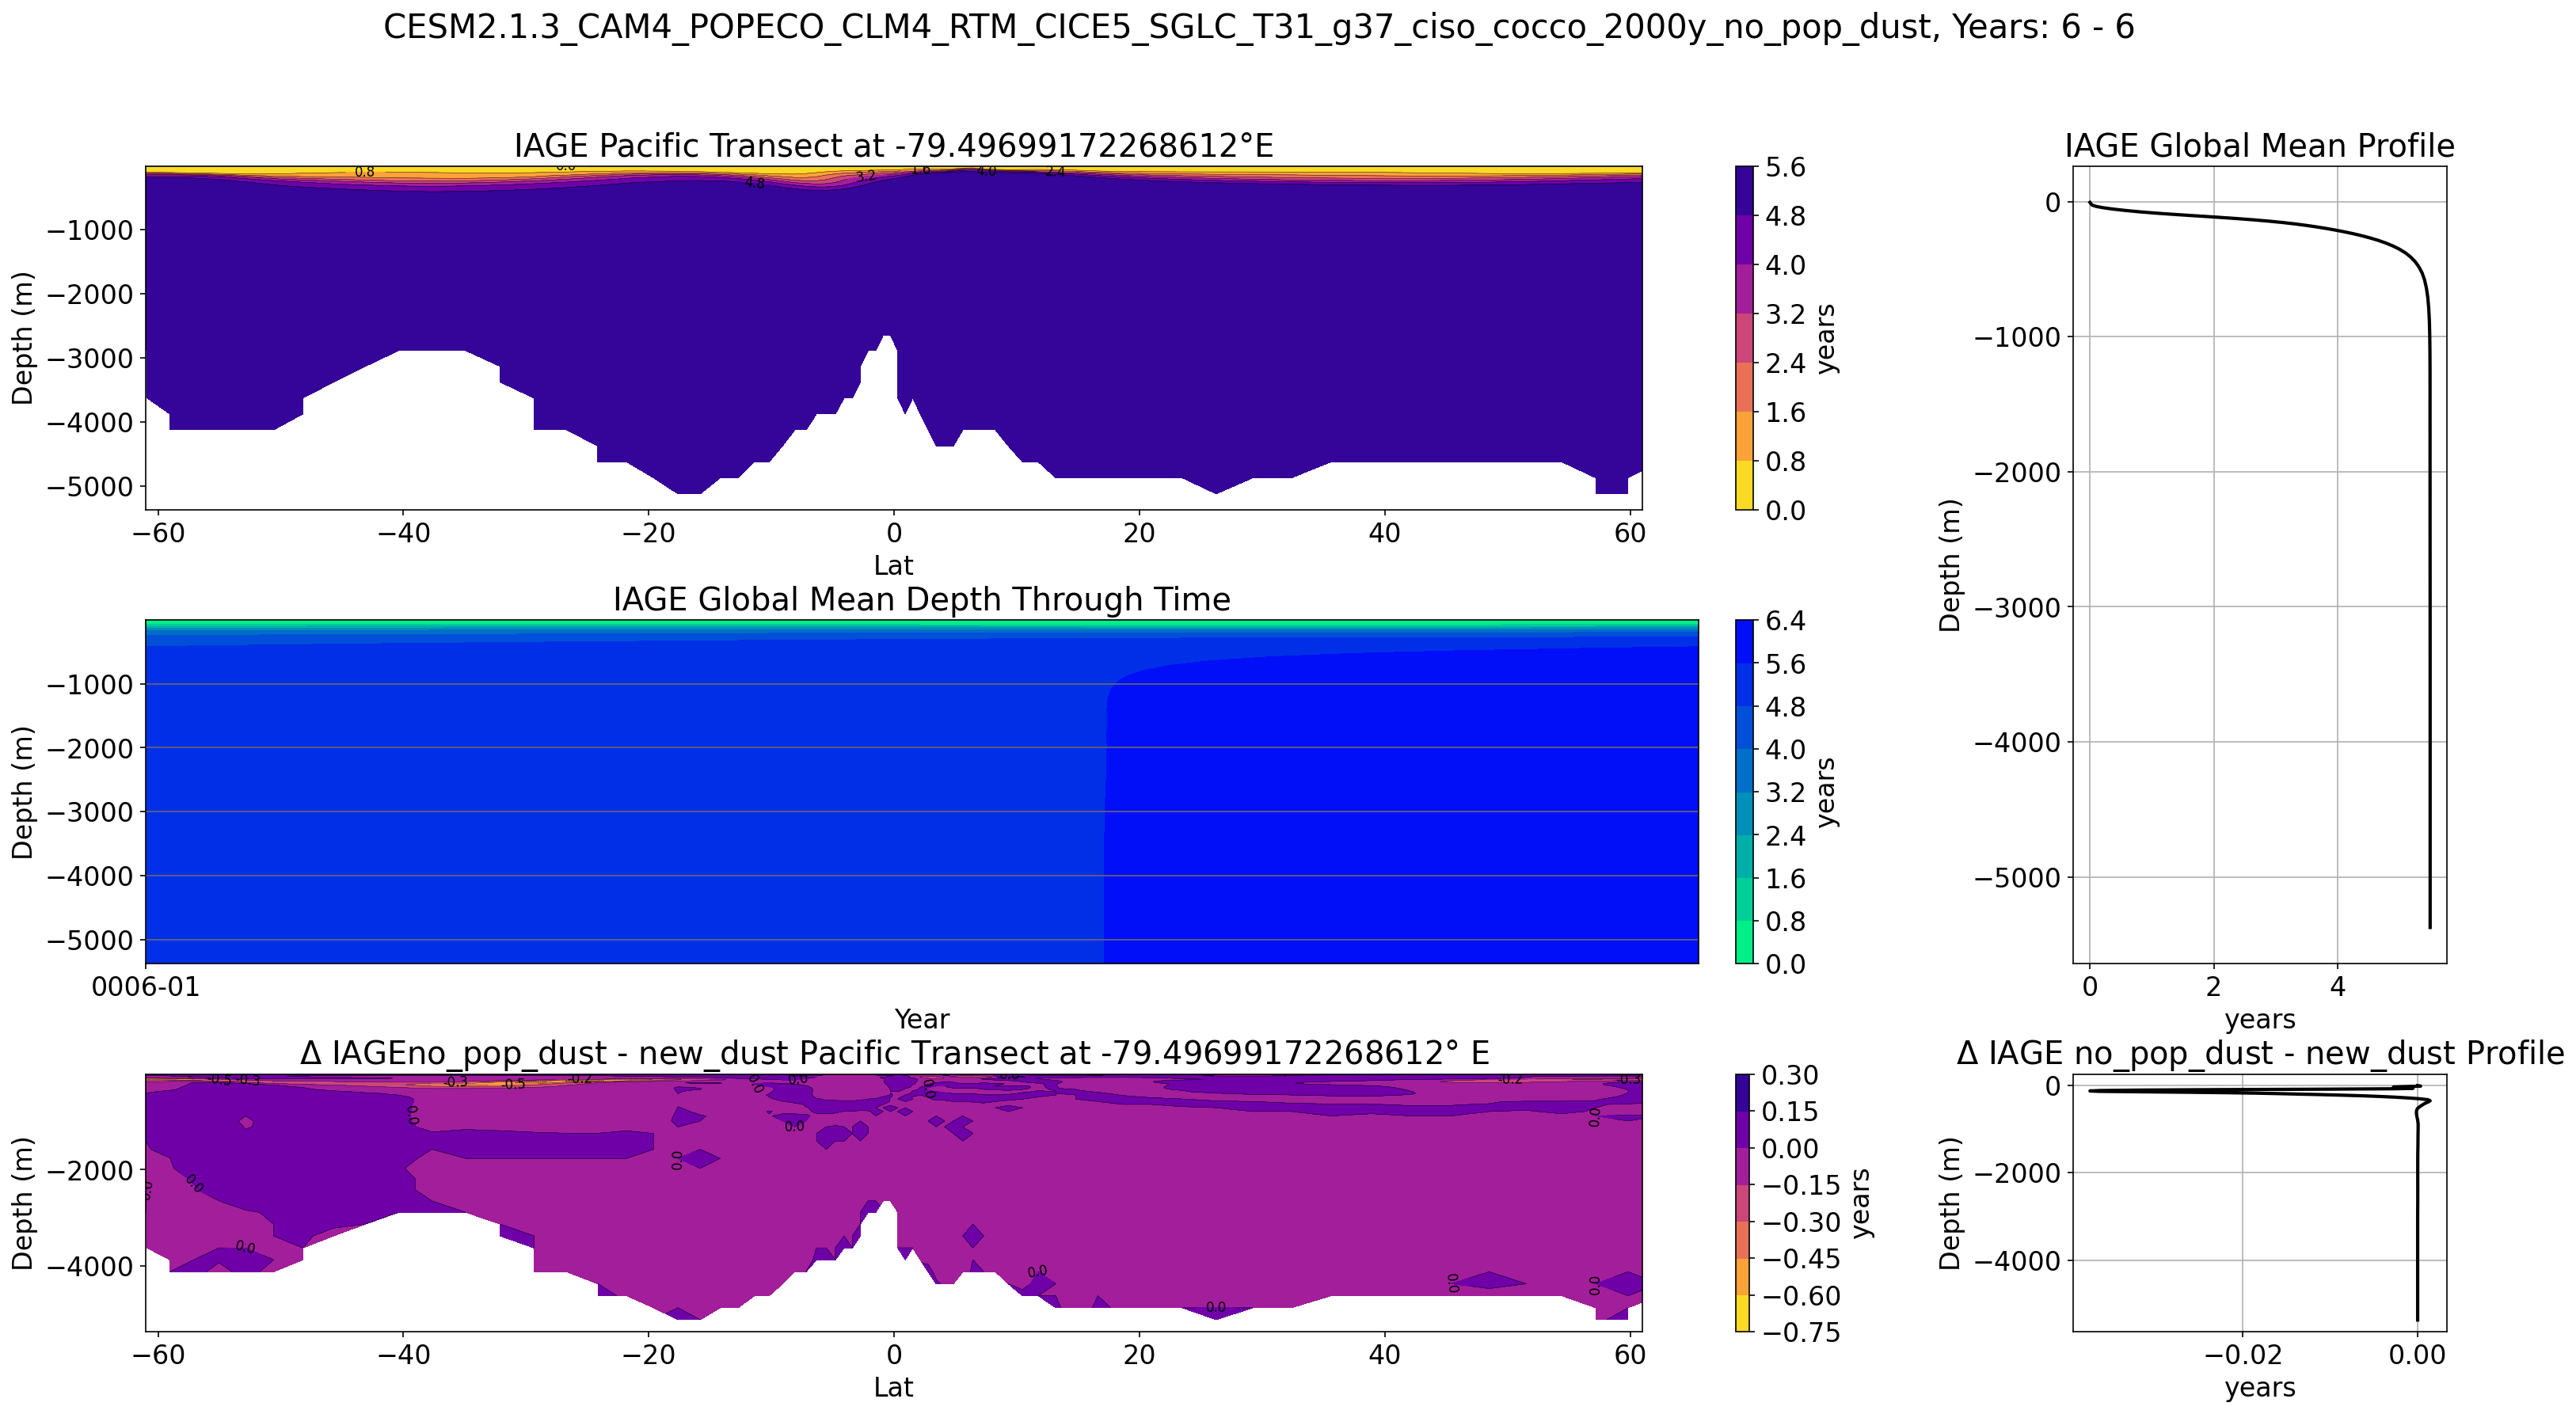

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cartopy.util as util
import matplotlib as mpl
from glob import glob



mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0



# function to take global weighted mean, keeping depth information
def global_mean_3D(var, weights):
    # make sure masking is correct, otherwise we get nans
    weights = np.ma.masked_invalid(weights)
    var = np.ma.masked_invalid(var)
    
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros([var.shape[0], var.shape[1]])

    # loop over time
    for t in np.arange(var.shape[0]):
    # loop over each depth slice
        for d in np.arange(var.shape[1]):
            ave[t,d] = np.ma.average(var[t,d,:,:], weights = weights)
    return ave

dates = []
years = []

if regrid == True:
    for year in range (startYear,endYear+1):
        years.append(str(year).zfill(4) + '-'+ str(1).zfill(2))
        for month in range (1,13):

            case = casePath + caseName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc'  
            newName = caseName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            !cdo -s remapbil,r100x116 -selname,$var $case /glade/scratch/vgarza/ScriptTempOutput/$newName &>> /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt
            #print(case)

            case = comparePath + compareName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc' 
            newName = compareName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            !cdo -s remapbil,r100x116 -selname,$var $case $remapLocation$newName &>> /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt


            dates.append(str(year).zfill(4) + '-'+ str(month).zfill(2))
        if year%5 == 0:
              print(case)

    data =  xr.open_mfdataset(remapLocation+caseName+'*'+'.nc')
    compareData=xr.open_mfdataset(remapLocation+compareName+'*'+'.nc')
else: 
    
    
    dataCase = []
    compareCase = []
    
    
    for year in range (startYear,endYear+1):
        years.append(str(year).zfill(4) + '-'+ str(1).zfill(2))
        
        for month in range (1,13):
          
            case = casePath + caseName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc' #sample one 0020-12.nc' 

            newName = caseName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            dataCase.extend(sorted(glob(case)))

            compare = comparePath + compareName + '.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            newName = compareName + '_' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc'
            compareCase.extend(sorted(glob(compare)))


            dates.append(str(year).zfill(4) + '-'+ str(month).zfill(2))

            
    data =  xr.open_mfdataset(dataCase)
    
    coords = {'x':'TLONG','y':'TLAT'}
    keepthese=['z_t','time','TAREA','lat','lon', 'time', var]
    keep_vars = keepthese +list(coords.values())
    data = data.drop([v for v in data.variables if v not in keep_vars])

    
    
    compareData = xr.open_mfdataset(compareCase)
    coords = {'x':'TLONG','y':'TLAT'}
    keepthese=['z_t','time','TAREA','lat','lon', 'time', var]
    keep_vars = keepthese +list(coords.values())
    compareData = compareData.drop([v for v in data.variables if v not in keep_vars])

    
    
    
    
mask = xr.open_mfdataset(casePath+caseName+'.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc') #sample one 0020-12.nc'*'+'.nc')
#mask['TAREA'].values = np.nan_to_num(mask['TAREA'].values)
globalMean = global_mean_3D(data[var],weights =mask.TAREA.values)

compMask = xr.open_mfdataset(comparePath+compareName+'.pop.h.' + str(year).zfill(4) + '-'+ str(month).zfill(2) + '.nc') #sample one 0020-12.nc'*'+'.nc')
#compMask['TAREA'].values = np.nan_to_num(compMask['TAREA'].values)
#globalMean = global_mean_3D(data[var],weights =mask.TAREA.values)
compareGlobalMean = global_mean_3D(compareData[var],weights =compMask.TAREA.values)

z_t = data.z_t
z_tCompare = compareData.z_t
depthi = 60

fig = plt.figure(figsize =(25,13),facecolor='white')
gs  = fig.add_gridspec(3, 2,width_ratios=[10, 2],height_ratios = [8,8,6], hspace=0.35,wspace=.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

#rightCol = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[0:2, 1])

ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, -1])

#fig, (ax1, ax2,ax3) = plt.subplots(2, 2,2 ) 


fig.suptitle(caseName + ', Years: ' + str(startYear) + ' - ' + str(endYear), fontsize=20)

#################################Transect####################################
zmaxi = 82 #41

getTLATandTLONG = xr.open_mfdataset(casePath + caseName + '.pop.h.0007-12'+'.nc',  decode_times=False)

mpl.rcParams['figure.figsize'] = [16,6]
clmap = 'plasma_r'

varData = np.mean(data[var][:,0:zmaxi,2:91,transectLong], axis = 0)

p = ax1.contourf(getTLATandTLONG[var].TLAT[2:91,transectLong], getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, cmap = clmap) #, levels, vmin = 32.8, vmax = 35.8, extend = 'both', cmap = cmap)
cbar = plt.colorbar(p, ax = ax1)
cbar.set_label(data[var].units)

cl = ax1.contour(getTLATandTLONG[var].TLAT[2:91,transectLong],getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData,
                 colors = 'k', linewidths = 0.2)
plt.clabel(cl, fmt='%2.1f', colors='k', fontsize=8)#, ax = ax1)

ax1.set_xlim([-61, 61])

ax1.set_xlabel('Lat')
ax1.set_ylabel('Depth (m)')

ax1.set_title(var+' Pacific Transect at '+str(getTLATandTLONG[var].TLAT[0,transectLong].values).zfill(4)+u"\N{DEGREE SIGN}"+'E')


#################################Depth#####################################
z_t = data.z_t
depthi = 60

clmap = 'winter_r'


p = ax2.contourf(dates, z_t[0:depthi]*(-1)*0.01, np.transpose(globalMean[:,0:depthi]), cmap = clmap)
cbar = plt.colorbar(p, ax = ax2, pad = 0.02)
cbar.set_label(var)
cbar.set_label(data[var].units)

ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Year')

ax2.set_xticks(ticks = years)
ax2.grid(color = 'dimgrey')

ax2.set_title(var + ' Global Mean Depth Through Time')

##############################Profile######################################
mean = np.mean(globalMean, axis = 0)


ax3.plot(mean, data.z_t*(-1)*0.01, 'k', label = var)


ax3.grid()

ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(data[var].units)

ax3.set_title(var + ' Global Mean Profile')


##############################Transect Anomaly######################################
zmaxi = 82 #41

getTLATandTLONG = xr.open_mfdataset(casePath + caseName + '.pop.h.0007-12'+'.nc',  decode_times=False)


mpl.rcParams['figure.figsize'] = [16,6]
clmap = 'plasma_r'

varData = np.mean(data[var][:,0:zmaxi,2:91,transectLong], axis = 0) - np.mean(compareData[var][:,0:zmaxi,2:91,transectLong], axis = 0)

p = ax4.contourf(getTLATandTLONG[var].TLAT[2:91,transectLong], getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, cmap = clmap) #, levels, vmin = 32.8, vmax = 35.8, extend = 'both', cmap = cmap)
cbar = plt.colorbar(p,ax = ax4)
cbar.set_label(data[var].units)

cl = ax4.contour(getTLATandTLONG[var].TLAT[2:91,transectLong],getTLATandTLONG[var].z_t[0:zmaxi]*(-1)*0.01, varData, colors = 'k', linewidths = 0.2)
plt.clabel(cl, fmt='%2.1f', colors='k', fontsize=8)

ax4.set_xlim([-61, 61])

ax4.set_xlabel('Lat')
ax4.set_ylabel('Depth (m)')

ax4.set_title('$\Delta$ '+ var + caseName[67:] + ' - ' + compareName[67:] + ' Pacific Transect at ' + str(getTLATandTLONG[var].TLAT[0,transectLong].values).zfill(4) + u"\N{DEGREE SIGN}" + ' E')

######################Profile Anomaly########################

mean = np.mean(globalMean, axis = 0) - np.mean(compareGlobalMean, axis = 0)


ax5.plot(mean, data.z_t*(-1)*0.01, 'k', label = var)



ax5.grid()

ax5.set_ylabel('Depth (m)')
ax5.set_xlabel(data[var].units)

ax5.set_title('$\Delta$ ' + var +' '+ caseName[67:] + ' - ' + compareName[67:] + ' Profile')




if savePlot == True: 
    #swap  . and / in case name with '_'
    x = "./"
    y = "__"
    mytable = caseName.maketrans(x, y)
    
    
    fig.savefig(saveLocation+caseName.translate(mytable)+ ' Diagnostic', bbox_inches='tight', quality = 95, dpi = 500)
    
if regrid == True:
    #remove the remapped files created in the beginning
   # !rm /glade/scratch/vgarza/ScriptTempOutput/$caseName*
   # !rm /glade/scratch/vgarza/ScriptTempOutput/$compareName*
    !rm /glade/scratch/vgarza/ScriptTempOutput/WarningFile.txt